<a href="https://colab.research.google.com/github/maxmigue/machineLearning/blob/main/LAB09_SVM_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratorio de Máquinas de Soporte Vectorial en Python

## Objetivo
El objetivo de este laboratorio es experimentar con un conjunto de datos artificial que sigue una distribución Gaussiana creada por el programador. Utilizaremos el kernel Gaussiano para aprender la estructura utilizando máquinas de Soporte Vectorial.


## Etapas Metodológicas

Se deben seguir las siguientes cinco etapas metodológicas:

1. **Obtención de datos**: Generar un conjunto de datos artificial siguiendo una distribución Gaussiana.

2. **Manipulación**: Dividir el conjunto de datos en conjuntos de entrenamiento, prueba y validación.

3. **Exploración**: Visualizar los datos para entender la distribución y la relación entre las categorías.

4. **Modelamiento**: Implementar un clasificador de Máquinas de Soporte Vectorial utilizando el kernel Gaussiano.

5. **Interpretación**: Analizar y discutir los resultados obtenidos, incluyendo las estadísticas de clasificación y los parámetros ajustados.

## Instrucciones

1. Crea un Jupyter notebook para llevar a cabo el laboratorio.

2. Genera un conjunto de datos artificial que siga una distribución Gaussiana concéntrica.

3. Divide el conjunto de datos en conjuntos de entrenamiento, prueba y validación.

4. Grafica los conjuntos de datos, asignando el color rojo a una categoría y el color azul a la otra.

5. Entrena un clasificador de Máquinas de Soporte Vectorial utilizando el kernel Gaussiano.

6. Muestra las estadísticas de clasificación (precisión, recall, F1-score, etc.).

7. Realiza ajustes en los parámetros del clasificador y documenta los cambios en el rendimiento.

8. Interpreta los resultados y concluye sobre la eficacia del modelo.

9. Entrega el Jupyter notebook con todos los pasos y explicaciones detalladas.

Recuerda documentar cada paso y proporcionar explicaciones claras y concisas en tu notebook. ¡Buena suerte!



#PASO 1 Obtención de datos

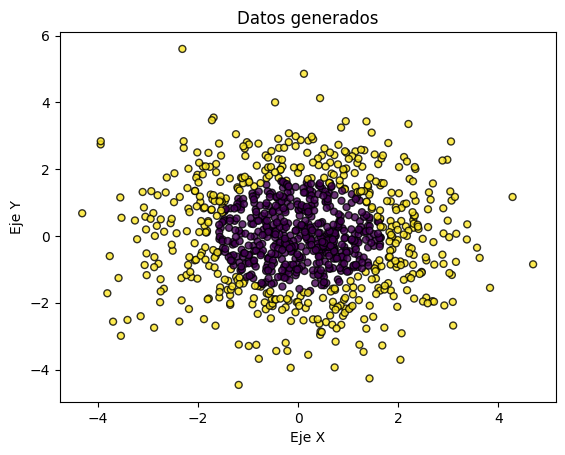

In [14]:
#create two gaussian distributions using make_gaussian_quantiles

from sklearn.datasets import make_gaussian_quantiles
import matplotlib.pyplot as plt
import numpy as np

#generate 2D normally distributed data
X1, Y1 = make_gaussian_quantiles(cov=2.,
                                    n_samples=1000, n_features=2,
                                    n_classes=2, random_state=1)

# plot  data. Seaborn, blue a red color, transparency.
plt.title("Datos generados")
plt.xlabel("Eje X")
plt.ylabel("Eje Y")
plt.scatter(X1[:, 0], X1[:, 1], marker='o', c=Y1,
            s=25, edgecolor='k', alpha=0.8)
plt.show()

# PASO 2: Manipulación de datos


DATAFRAME: 
      Eje X     Eje Y  Label
0 -1.140108  0.069384      0
1  1.533599 -0.155701      0
2 -1.559834  1.074086      1
3  1.239134  0.174310      0
4 -2.794104 -0.832874      1

DATAFRAME SIN OUTLIERS: 
      Eje X     Eje Y  Label
0 -1.140108  0.069384      0
1  1.533599 -0.155701      0
2 -1.559834  1.074086      1
3  1.239134  0.174310      0
4 -2.794104 -0.832874      1


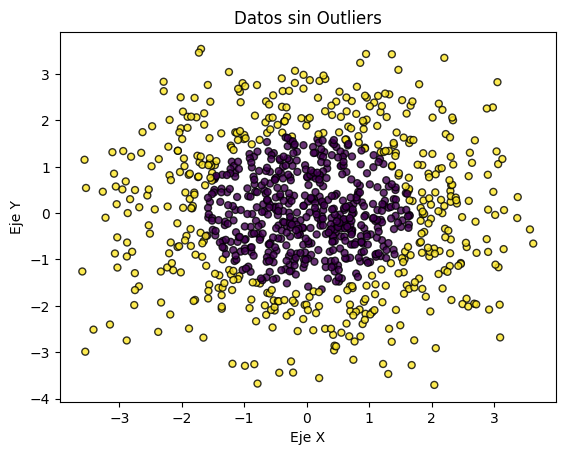

In [22]:
# Limpieza de los datos, normalización, datos faltantes, extremos, etc

import pandas as pd

# Convertimos a dataframe
df = pd.DataFrame(X1, columns=['Eje X', 'Eje Y'])
df['Label'] = Y1

print("DATAFRAME: ")
print(df.head())

# Calcular Q1 (percentil 25) y Q3 (percentil 75)
Q1 = df[['Eje X', 'Eje Y']].quantile(0.25)
Q3 = df[['Eje X', 'Eje Y']].quantile(0.75)
IQR = Q3 - Q1

# Se detectan y eliminan valores extremos, ya que SVM es sensible a estos
df_sin_outliers = df[~((df[['Eje X', 'Eje Y']] < (Q1 - 1.5 * IQR)) |
                       (df[['Eje X', 'Eje Y']] > (Q3 + 1.5 * IQR))).any(axis=1)]

# Grafica del dataframe sin los outliers
print("\nDATAFRAME SIN OUTLIERS: ")
print(df_sin_outliers.head())

plt.scatter(df_sin_outliers['Eje X'],
            df_sin_outliers['Eje Y'],
            c=df_sin_outliers['Label'],
            s=25, edgecolor='k', alpha=0.8)

plt.title("Datos sin Outliers")
plt.xlabel("Eje X")
plt.ylabel("Eje Y")
plt.show()


In [39]:
# Ver si hay valores faltantes:
print(df_sin_outliers.isnull().sum())

Eje X    0
Eje Y    0
Label    0
dtype: int64


Como se observa, no hay presencia de valores faltantes

In [40]:
# Con los datos listos, se realiza la normalización de estos
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_normalizado = df_sin_outliers.copy()
df_normalizado[['Eje X', 'Eje Y']] = scaler.fit_transform(df_normalizado[['Eje X', 'Eje Y']])

print("DATOS NORMALIZADOS: \n")
print(df_normalizado.head())


DATOS NORMALIZADOS: 

      Eje X     Eje Y  Label
0 -0.875619  0.024363      0
1  1.060427 -0.140795      0
2 -1.179545  0.761577      1
3  0.847202  0.101354      0
4 -2.073286 -0.637680      1


#PASO 3: Exploración de Datos

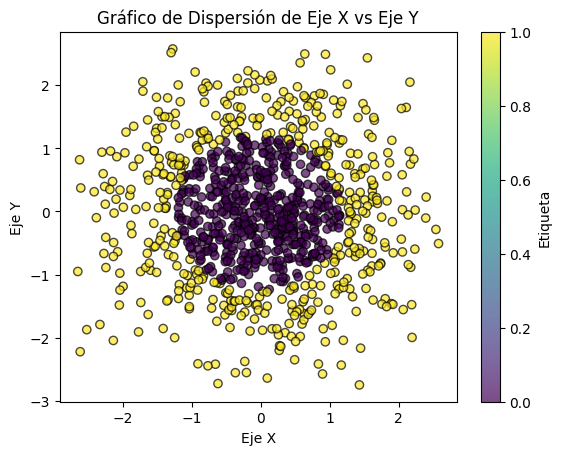

In [41]:
# Realizar gráficas para ver lo que está pasando, pueden ser tablas también

plt.scatter(df_normalizado['Eje X'], df_normalizado['Eje Y'], c=df_normalizado['Label'], cmap='viridis', alpha=0.7, edgecolor='k')
plt.title("Gráfico de Dispersión de Eje X vs Eje Y")
plt.xlabel("Eje X")
plt.ylabel("Eje Y")
plt.colorbar(label='Etiqueta')
plt.show()


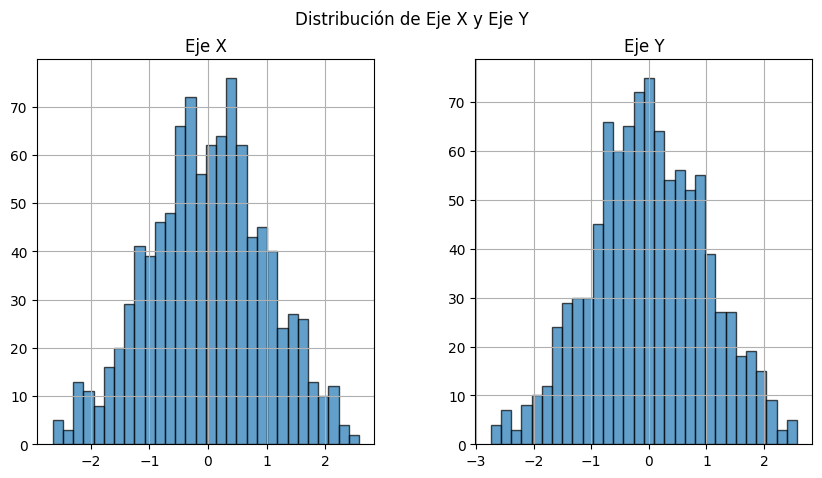

In [42]:
df_normalizado[['Eje X', 'Eje Y']].hist(bins=30, figsize=(10, 5), edgecolor='k', alpha=0.7)
plt.suptitle("Distribución de Eje X y Eje Y")
plt.show()

Se presenta una distribución normal en este conjunto de datos.

# PASO 4: Modelamiento de Datos (Machine Learning)

In [44]:
# Función para graficar SVM

def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)

    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, edgecolors='black',
                   facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


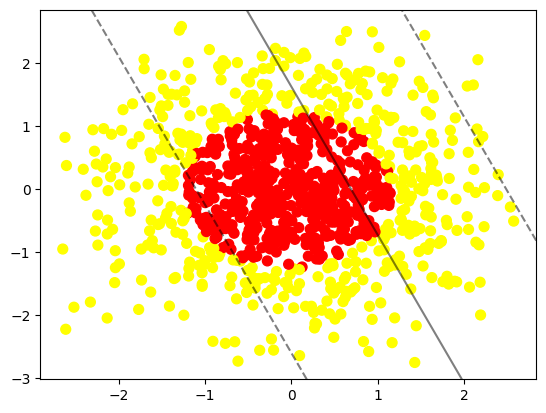

In [46]:
# Realizar el modelo, configuración de parámetros

from sklearn.svm import SVC
data = SVC(kernel='linear').fit(df_normalizado[["Eje X", "Eje Y"]], df_normalizado["Label"])

plt.scatter(df_normalizado["Eje X"], df_normalizado["Eje Y"], c=df_normalizado["Label"], s=50, cmap='autumn')
plot_svc_decision_function(data, plot_support=False);

#PASO 5: Interpretación de los Resultados